In [14]:
!rm -rf runs videos

## Environment Setup

In [ ]:
!pip install gym-tetris
!pip install tensorboardX
!pip install pyglet==1.5.1
!pip install torchsummary
!pip install optuna
!pip install optuna-dashboard

In [ ]:
!pip install setuptools==65.5.1
!pip install gym==0.21.0
!pip install stable-baselines3[extra]

In [ ]:
!pip install pyvirtualdisplay
!apt-get install -y xvfb

In [1]:
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1024, 768))
virtual_display.start()

## Tests

In [ ]:
from nes_py.wrappers import JoypadSpace
import gym_tetris
from gym_tetris.actions import MOVEMENT

env = gym_tetris.make('TetrisA-v0')
env = JoypadSpace(env, MOVEMENT)

print("action space: ", env.action_space.shape)
#print("observation space: ", env.observation_shape.shape)

done = True
for step in range(1):
    if done:
        state = env.reset()
    print(state.shape)
    state, reward, done, info = env.step(env.action_space.sample())
    print(info)
    env.render()

env.close()

action space:  ()
(240, 256, 3)
{'current_piece': 'Jd', 'number_of_lines': 0, 'score': 0, 'next_piece': 'Ih', 'statistics': {'T': 0, 'J': 1, 'Z': 0, 'O': 0, 'S': 0, 'L': 0, 'I': 0}, 'board_height': 0}


In [ ]:
from nes_py.wrappers import JoypadSpace
import gym_tetris
from gym_tetris.actions import MOVEMENT

envs = gym.vector.SyncVectorEnv([make_env(env_id="SpaceInvadersNoFrameskip-v4", seed=1, idx=0, capture_video=0, run_name="test")])

print("action space: ", envs.action_space.shape)
#print("observation space: ", env.observation_shape.shape)

done = True
for step in range(1):
    if done:
        state = envs.reset()
    print(state.shape)
    state, reward, done, info = envs.step(envs.action_space.sample())
    print(info)
    #envs.render()

envs.close()

action space:  None
(1, 4, 84, 84)
[{'lives': 3, 'episode_frame_number': 3, 'frame_number': 3}]


In [ ]:
envs = gym.vector.SyncVectorEnv([make_env(env_id="TetrisA-v0", seed=1, idx=0, capture_video=0, run_name="test")])
print("action space: ", envs.action_space)
print("observation space: ", envs.observation_space)
print("single action space: ", envs.single_action_space)
print("single observation space: ", envs.single_observation_space)

In [ ]:
envs = gym.vector.SyncVectorEnv([make_env(env_id="SpaceInvadersNoFrameskip-v4", seed=1, idx=0, capture_video=0, run_name="test")])
print("action space: ", envs.action_space)
print("observation space: ", envs.observation_space.shape)
print("single action space: ", envs.single_action_space)
#print("single observation space: ", envs.single_observation_space)

action space:  Tuple(Discrete(6))
observation space:  (1, 4, 84, 84)
single action space:  Discrete(6)


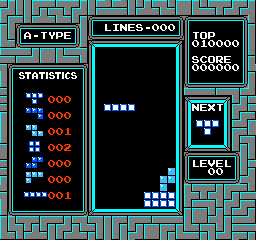

KeyboardInterrupt: ignored

In [ ]:
import io
import time
import IPython.display
from PIL import Image
from nes_py.wrappers import JoypadSpace
import gym_tetris
from gym_tetris.actions import MOVEMENT

env = gym_tetris.make('TetrisA-v0')
env = JoypadSpace(env, MOVEMENT)

done = True
for step in range(5000):
    if done:
        state = env.reset()
    state, reward, done, info = env.step(env.action_space.sample())

    # Capture the current game frame
    buffer = io.BytesIO()
    img = env.render(mode='rgb_array')
    Image.fromarray(img).save(buffer, 'PNG')
    buffer.seek(0)

    # Display the frame using IPython.display
    IPython.display.clear_output(wait=True)
    IPython.display.display(Image.open(buffer))

    # Sleep for a short duration (optional, to control the frame rate)
    #time.sleep(0.1)

IPython.display.clear_output(wait=True)
env.close()

## Training

In [2]:
import os
import sys
import random
import time
from distutils.util import strtobool

import gym
import numpy as np
import torch
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from stable_baselines3.common.atari_wrappers import (
    ClipRewardEnv,
    EpisodicLifeEnv,
    FireResetEnv,
    MaxAndSkipEnv,
    NoopResetEnv,
)
from stable_baselines3.common.buffers import ReplayBuffer
from torch.utils.tensorboard import SummaryWriter

# Get the absolute path to the parent directory of gym-tetris
gym_tetris_parent_path = os.path.abspath(os.path.join('..', 'gym-tetris'))

# Append the path to the sys.path
sys.path.append(gym_tetris_parent_path)

from nes_py.wrappers import JoypadSpace
import gym_tetris
from gym_tetris.actions import MOVEMENT

In [3]:
class QNetwork(nn.Module):
    def __init__(self, actions_num, arch_fn):
        super().__init__()
        self.network = arch_fn(actions_num)

    def forward(self, x):
        return self.network(x / 255.0)

def original(actions_num):
    network = nn.Sequential(
        nn.Conv2d(1, 32, 8, stride=4),
        nn.ReLU(),
        nn.Conv2d(32, 64, 4, stride=2),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=1),
        nn.ReLU(),
        nn.Flatten(),
        nn.Dropout(0.2),
        nn.Linear(3136, 512),
        nn.Dropout(0.2),
        nn.ReLU(),
        nn.Linear(512, actions_num),
    )
    return network

def tiny(actions_num):
    network = nn.Sequential(
        nn.Conv2d(1, 8, 3, stride=1),
        nn.ReLU(),
        nn.Conv2d(8, 16, 5, stride=3),
        nn.ReLU(),
        nn.Conv2d(16, 32, 5, stride=3),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(2048, 128),
        nn.Dropout(0.1),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.Dropout(0.5),
        nn.ReLU(),
        nn.Linear(64, actions_num),
    )
    return network

def small(actions_num):
    network = nn.Sequential(
        # (1, 84, 84)
        nn.Conv2d(1, 64, 7, stride=3),
        nn.ReLU(),
        # (64, 26, 26)
        nn.Conv2d(64, 128, 5),
        nn.ReLU(),
        # (128, 22, 22)
        nn.MaxPool2d(2),
        # (128, 11, 11)
        nn.Conv2d(128, 128, 3),
        nn.ReLU(),
        # (128, 8, 8)
        nn.Conv2d(128, 256, 3),
        nn.ReLU(),
        # (256, 6, 6)
        nn.Conv2d(256, 256, 3),
        nn.ReLU(),
        # (256, 4, 4)
        nn.MaxPool2d(2),
        # (256, 2, 2)
        nn.Flatten(),
        # 1024
        nn.Dropout(0.5),
        nn.Linear(1024, 256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256, actions_num)
        # 12 possible actions
    )
    return network

def large(actions_num):
    network = nn.Sequential(
        # (1, 84, 84)
        nn.Conv2d(1, 64, 7, stride=3),
        nn.ReLU(),
        # (128, 26, 26)
        nn.MaxPool2d(2),
        # (128, 13, 13)
        nn.Conv2d(64, 128, 4),
        nn.ReLU(),
        # (128, 10, 10)
        nn.Conv2d(128, 256, 3),
        nn.ReLU(),
        # (256, 8, 8)
        nn.MaxPool2d(2),
        # (256, 4, 4)
        nn.Flatten(),
        # 4096
        nn.Dropout(0.5),
        nn.Linear(4096, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, actions_num),
        # 12 possible actions
    )
    return network

def atari(actions_num):
    network = nn.Sequential(
        # (1, 84, 84)
        nn.Conv2d(1, 16, 8, stride=4),
        nn.ReLU(),
        # (16, 20, 20)
        nn.Conv2d(16, 32, 4, stride=2),
        nn.ReLU(),
        # (32, 9, 9)
        nn.Flatten(),
        # 2592
        nn.Linear(2592, 256),
        nn.ReLU(),
        nn.Linear(256, actions_num),
    )
    return network



def get_model_class(architecture="original"):
    if architecture == "original":
        class OriginalQNetwork(QNetwork):
            def __init__(self, env):
                super().__init__(env, original)
        return OriginalQNetwork
    elif architecture == "tiny":
        class TinyQNetwork(QNetwork):
            def __init__(self, env):
                super().__init__(env, tiny)
        return TinyQNetwork
    elif architecture == "small":
        class SmallQNetwork(QNetwork):
            def __init__(self, env):
                super().__init__(env, small)
        return SmallQNetwork
    elif architecture == "large":
        class LargeQNetwork(QNetwork):
            def __init__(self, env):
                super().__init__(env, large)
        return LargeQNetwork
    elif architecture == "atari":
        class AtariQNetwork(QNetwork):
            def __init__(self, env):
                super().__init__(env, atari)
        return AtariQNetwork
    else:
        print("Not a valid architecture")

def linear_schedule(start_e: float, end_e: float, duration: int, t: int):
    slope = (end_e - start_e) / duration
    return max(slope * t + start_e, end_e)

In [ ]:
Network = get_model_class("atari")
model = Network(12)
summary(model, (1, 84, 84), batch_size=16, device="cpu")
x = torch.randn(1, 84, 84)
out = model(x)

### training

In [4]:
def train(args, trial=None):
  try:
    run_name = f"{args.env_id}__{args.exp_name}__{args.seed}__{int(time.time())}"
    prefix = ""
    if trial:
      run_name += f"_trial_{trial.number}"
      prefix = f"trial {trial.number}: "
    if args.track:
        import wandb

        wandb.init(
            project=args.wandb_project_name,
            entity=args.wandb_entity,
            sync_tensorboard=True,
            config=vars(args),
            name=run_name,
            monitor_gym=True,
            save_code=True,
        )
    writer = SummaryWriter(f"runs/{run_name}")
    writer.add_text(
        "hyperparameters",
        "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(args).items()])),
    )

    # TRY NOT TO MODIFY: seeding
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.backends.cudnn.deterministic = args.torch_deterministic

    device_name = "cuda" if torch.cuda.is_available() and args.cuda else "cpu"
    device_name = "mps" if torch.backends.mps.is_available() and args.mps else device_name
    device = torch.device(device_name)

    # env setup
    env_fns = [make_env(args.env_id, args.seed, i, args.capture_video, run_name, args.video_frequency) for i in range(args.env_cnt)]
    envs = gym.vector.SyncVectorEnv(env_fns)
    assert isinstance(envs.single_action_space, gym.spaces.Discrete), "only discrete action space is supported"

    q_network = args.QNetwork(envs.single_action_space.n).to(device)
    optimizer = optim.Adam(q_network.parameters(), lr=args.learning_rate)
    target_network = args.QNetwork(envs.single_action_space.n).to(device)
    target_network.load_state_dict(q_network.state_dict())

    #summary(q_network, input_size=(1, 84, 84), batch_size=args.batch_size, device=device_name)

    rb = ReplayBuffer(
        args.buffer_size,
        envs.single_observation_space,
        envs.single_action_space,
        device,
        n_envs=args.env_cnt,
        optimize_memory_usage=False,
        handle_timeout_termination=True,
    )
    start_time = time.time()
    eval_idx = 1

    # TRY NOT TO MODIFY: start the game
    obs = envs.reset()
    for global_step in range(args.total_timesteps):
        # ALGO LOGIC: put action logic here
        epsilon = linear_schedule(args.start_e, args.end_e, args.exploration_fraction * args.total_timesteps, global_step)
        if random.random() < epsilon:
            actions = np.array([envs.single_action_space.sample() for _ in range(envs.num_envs)])
        else:
            q_values = q_network(torch.Tensor(obs).to(device))
            actions = torch.argmax(q_values, dim=1).cpu().numpy()

        # TRY NOT TO MODIFY: execute the game and log data.
        next_obs, rewards, dones, infos = envs.step(actions)

        # TRY NOT TO MODIFY: record rewards for plotting purposes
        for info in infos:
            if "episode" in info.keys():
                print(f"{prefix}global_step={global_step}, episodic_return={info['episode']['r']}")
                writer.add_scalar("charts/episodic_return", info["episode"]["r"], global_step)
                writer.add_scalar("charts/episodic_length", info["episode"]["l"], global_step)
                writer.add_scalar("charts/episodic_score", info["score"], global_step)
                writer.add_scalar("charts/epsilon", epsilon, global_step)

            # Evaluate and report the agent periodically
            if trial and global_step % args.eval_frequency == 0 and global_step > 0:
                episodic_returns = evaluate(q_network, make_env, args.env_id, args.eval_episodes, f"{run_name}-eval-{eval_idx}", args.QNetwork, args.seed, device, args.eval_epsilon, capture_video=False)
                mean_return = np.mean(episodic_returns)
                mean_score = np.mean(episodic_scores)
                print(f"{prefix}evaluation_{eval_idx} mean_return={mean_return} mean_score={mean_score}")
                trial.set_user_attr("mean_score", float(mean_score))
                trial.report(mean_return, global_step)
                eval_idx += 1

                # Check if the trial should be pruned
                if trial and trial.should_prune():
                    raise optuna.exceptions.TrialPruned()
                break

        # TRY NOT TO MODIFY: save data to reply buffer; handle `terminal_observation`
        real_next_obs = next_obs.copy()
        #for idx, d in enumerate(dones):
            #if d:
                #real_next_obs[idx] = infos[idx]["terminal_observation"]  //Tetris environment does not set a terminal observation.
        rb.add(obs, real_next_obs, actions, rewards, dones, infos)

        # TRY NOT TO MODIFY: CRUCIAL step easy to overlook
        obs = next_obs

        # ALGO LOGIC: training.
        if global_step > args.learning_starts:
            if global_step % args.train_frequency == 0:
                data = rb.sample(args.batch_size)
                with torch.no_grad():
                    target_max, _ = target_network(data.next_observations).max(dim=1)
                    td_target = data.rewards.flatten() + args.gamma * target_max * (1 - data.dones.flatten())
                old_val = q_network(data.observations).gather(1, data.actions).squeeze()
                loss = F.mse_loss(td_target, old_val)

                if global_step % 100 == 0:
                    writer.add_scalar("losses/td_loss", loss, global_step)
                    writer.add_scalar("losses/q_values", old_val.mean().item(), global_step)
                    # print("SPS:", int(global_step / (time.time() - start_time)))    # steps per second
                    writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)

                # optimize the model
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # update target network
            if global_step % args.target_network_frequency == 0:
                for target_network_param, q_network_param in zip(target_network.parameters(), q_network.parameters()):
                    target_network_param.data.copy_(
                        args.tau * q_network_param.data + (1.0 - args.tau) * target_network_param.data
                    )
                    
            if args.save_model and global_step % args.backup_frequency == 0:
                model_backup_path = f"runs/{run_name}/{args.exp_name}.backup"
                torch.save(q_network.state_dict(), model_backup_path)

    if args.save_model:
        model_path = f"runs/{run_name}/{args.exp_name}.cleanrl_model"
        torch.save(q_network.state_dict(), model_path)
        print(f"{prefix}model saved to {model_path}")

        episodic_returns, episodic_scores = evaluate(
            model_path,
            make_env,
            args.env_id,
            args.eval_episodes,
            run_name=f"{run_name}-eval-{eval_idx}",
            Model=args.QNetwork,
            seed=args.seed,
            device=device,
            epsilon=args.eval_epsilon,
            capture_video=args.capture_video
        )
        
        mean_return = np.mean(episodic_returns)
        mean_score = np.mean(episodic_scores)
        print(f"{prefix}evaluation_{eval_idx} mean_return={mean_return} mean_score={mean_score}")
        if trial:
            trial.set_user_attr("mean_return", float(mean_return))
            trial.set_user_attr("mean_score", float(mean_score))
        for idx, episodic_return in enumerate(episodic_returns):
            writer.add_scalar("eval/episodic_return", episodic_return, idx)

        if args.upload_model:
            pass
            from cleanrl_utils.huggingface import push_to_hub

            repo_name = f"{args.env_id}-{args.exp_name}-seed{args.seed}"
            repo_id = f"{args.hf_entity}/{repo_name}" if args.hf_entity else repo_name
            push_to_hub(args, episodic_returns, repo_id, "DQN", f"runs/{run_name}", f"videos/{run_name}-eval")
  except:
    raise
  finally:
    envs.close()
    writer.close()

In [5]:
def make_env(env_id, seed, idx, capture_video, run_name, video_freq=100):
    def thunk():
        env = gym_tetris.make(env_id)
        env = JoypadSpace(env, MOVEMENT)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        if capture_video:
            if idx == 0:
                env = gym.wrappers.RecordVideo(env, f"videos/{run_name}", episode_trigger=lambda ep_num: ep_num % video_freq == 0)
        #env = NoopResetEnv(env, noop_max=30)
        #env = MaxAndSkipEnv(env, skip=4)
        #env = EpisodicLifeEnv(env)
        #env = ClipRewardEnv(env)
        env = gym.wrappers.ResizeObservation(env, (84, 84))
        env = gym.wrappers.GrayScaleObservation(env)
        env = gym.wrappers.FrameStack(env, 1)
        env.seed(seed)
        env.action_space.seed(seed)
        env.observation_space.seed(seed)
        return env

    return thunk

### Cleanrl utils

In [6]:
from typing import Callable, Union

def evaluate(
    model_input: Union[str, torch.nn.Module],
    make_env: Callable,
    env_id: str,
    eval_episodes: int,
    run_name: str,
    Model: torch.nn.Module,
    seed: int,
    device: torch.device = torch.device("cpu"),
    epsilon: float = 0.05,
    capture_video: bool = True,
    video_frequency: int = 1,
    env_cnt: int = 1
):
    env_fns = [make_env(env_id, seed, i, capture_video, run_name, video_frequency) for i in range(env_cnt)]
    envs = gym.vector.SyncVectorEnv(env_fns)
    if isinstance(model_input, str):
        model = Model(envs.single_action_space.n).to(device)
        model.load_state_dict(torch.load(model_input, map_location=device))
    elif isinstance(model_input, torch.nn.Module):
        model = model_input
    else:
        raise ValueError("Invalid model_input. It should be either a path (str) or a model instance (torch.nn.Module).")
    model.eval()

    obs = envs.reset()
    episodic_returns = []
    episodic_scores = []
    while len(episodic_returns) < eval_episodes:
        #if random.random() < epsilon:
            #actions = np.array([envs.single_action_space.sample() for _ in range(envs.num_envs)])
        #else:
        q_values = model(torch.Tensor(obs).to(device))
        actions = torch.argmax(q_values, dim=1).cpu().numpy()
        next_obs, _, _, infos = envs.step(actions)
        for info in infos:
            if "episode" in info.keys():
                print(f"eval_episode={len(episodic_returns)}, episodic_return={info['episode']['r']}")
                episodic_returns += [info["episode"]["r"]]
                episodic_scores += [info["score"]]
        obs = next_obs
    envs.close()
    return episodic_returns, episodic_scores

## main

In [ ]:
# # Short Run
# class Args:
#     def __init__(self):
#         self.env_id = "TetrisA-v0"
#         self.exp_name = "dqn"
#         self.seed = 1
#         self.torch_deterministic = True
#         self.cuda = True
#         self.mps = False
#         self.track = False
#         self.wandb_project_name = "cleanRL"
#         self.wandb_entity = None
#         self.capture_video = True
#         self.save_model = True
#         self.upload_model = False
#         self.backup_model = True
#         self.backup_frequency = 1000
#         self.hf_entity = ""
#         self.total_timesteps = 20000
#         self.video_frequency = 100
#         self.env_cnt = 2

#         # evaluations
#         self.total_evaluations = 2
#         self.eval_episodes = 4
#         self.eval_frequency = int(self.total_timesteps / self.total_evaluations)
#         self.eval_epsilon = 0.05

#         # Trainable hyperparameters
#         self.QNetwork = None
#         self.learning_rate = None
#         self.buffer_size = None
#         self.gamma = None
#         self.tau = None
#         self.target_network_frequency = None
#         self.batch_size = None
#         self.start_e = None
#         self.end_e = None
#         self.exploration_fraction = None
#         self.learning_starts = None
#         self.train_frequency = None

# args = Args()

In [7]:
#Weeklong args
class Args:
    def __init__(self):
        self.exp_name = "Tetris_DQN"
        self.seed = 1
        self.torch_deterministic = True
        self.cuda = False
        self.mps = True
        self.track = False
        self.wandb_project_name = "cleanRL"
        self.wandb_entity = None
        self.capture_video = True
        self.save_model = True
        self.upload_model = False
        self.hf_entity = ""
        self.env_id = "TetrisA-v6"
        self.total_timesteps = 200000
        self.learning_rate = 1e-4
        self.buffer_size = 20000
        self.gamma = 0.99
        self.tau = 0.999
        self.target_network_frequency = 1000
        self.batch_size = 32
        self.start_e = 1
        self.end_e = 0.02
        self.exploration_fraction = 0.60
        self.learning_starts = 5000
        self.train_frequency = 4
        self.video_frequency = 10
        self.env_cnt = 1
        self.QNetwork = get_model_class("atari")
        self.backup_model = True
        self.backup_frequency = 10000

        # evaluations
        self.total_evaluations = 2
        self.eval_episodes = 4
        self.eval_frequency = int(self.total_timesteps / self.total_evaluations)
        self.eval_epsilon = 0.05

args = Args()

In [8]:
train(args)

global_step=8920, episodic_return=-57.5
global_step=18244, episodic_return=-39.0
global_step=25769, episodic_return=-155.0
global_step=30320, episodic_return=-128.0
global_step=35357, episodic_return=-96.5
global_step=41744, episodic_return=-133.5
global_step=50467, episodic_return=-82.5
global_step=57578, episodic_return=-73.0
global_step=61255, episodic_return=-20.0
global_step=68171, episodic_return=-97.5
global_step=74417, episodic_return=-20.5
global_step=79902, episodic_return=-19.5
global_step=83874, episodic_return=-28.5
global_step=85618, episodic_return=-96.5
global_step=87886, episodic_return=-47.5
global_step=90888, episodic_return=-133.0
global_step=93663, episodic_return=-45.5
global_step=96821, episodic_return=-23.0
global_step=98974, episodic_return=-55.5
global_step=100635, episodic_return=-82.0
global_step=105281, episodic_return=-34.5
global_step=108063, episodic_return=17.0
global_step=110474, episodic_return=-58.5
global_step=113200, episodic_return=-126.5
global_s

## Optuna Hyperparameters Tuning

In [ ]:
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
from optuna.visualization import plot_optimization_history, plot_param_importances

In [ ]:
N_TRIALS = 100  # Maximum number of trials
N_JOBS = 2 # Number of jobs to run in parallel
N_STARTUP_TRIALS = 5  # Stop random sampling after N_STARTUP_TRIALS
N_EVALUATIONS = 2  # Number of evaluations during the training
# N_TIMESTEPS = int(2e4)  # Training budget
# EVAL_FREQ = int(N_TIMESTEPS / N_EVALUATIONS)
# N_EVAL_ENVS = 5
# N_EVAL_EPISODES = 10
TIMEOUT = int(60 * 15)  # 15 minutes

#ENV_ID = "TetrisA-v0"

In [ ]:
def sample_params(trial: optuna.Trial) -> dict:
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True),
        "buffer_size": trial.suggest_int("buffer_size", 1000, 5000),
        "gamma": 1.0 - trial.suggest_float("gamma", 0.0001, 0.1, log=True),
        "tau": 1.0 - trial.suggest_float("tau", 0.00001, 0.1, log=True),
        "target_network_frequency": trial.suggest_int("target_network_frequency", 50, 500),
        "batch_size": trial.suggest_categorical("batch_size", [16, 32, 64, 128]),
        "start_e": trial.suggest_float("start_e", 0.8, 1.0),
        "end_e": trial.suggest_float("end_e", 0.001, 0.1),
        "exploration_fraction": trial.suggest_float("exploration_fraction", 0.1, 0.9),
        "learning_starts": trial.suggest_int("learning_starts", 1000, 5000),
        "train_frequency": trial.suggest_int("train_frequency", 1, 10),
        "QNetwork": get_model_class(trial.suggest_categorical("model_size", ["tiny", "small", "original", "large", "atari"]))
    }
    return params

In [ ]:
def objective(trial: optuna.Trial):
    args = Args()
    hyperparameters = sample_params(trial)
    for key, value in hyperparameters.items():
        setattr(args, key, value)

    nan_encountered = False
    try:
      train(args, trial)
    except AssertionError as e:
      # Sometimes, random hyperparams can generate NaN
      print(e)
      nan_encountered = True
    except optuna.exceptions.TrialPruned:
      raise

    # Tell the optimizer that the trial failed
    if nan_encountered:
        return float("nan")

    return trial.user_attrs["mean_return"]

In [ ]:
study_name = f"{args.env_id}-{args.exp_name}-test"
study_num = 1

In [ ]:
args = Args()

# Set pytorch num threads to 1 for faster training
torch.set_num_threads(1)
# Select the sampler, can be random, TPESampler, CMAES, ...
sampler = TPESampler(n_startup_trials=N_STARTUP_TRIALS)
# Do not prune before 1/3 of the max budget is used
pruner = MedianPruner(
    n_startup_trials=N_STARTUP_TRIALS, n_warmup_steps=args.total_timesteps // 3
)
# Create the study and start the hyperparameter optimization
study = optuna.create_study(study_name=f"{study_name}-{study_num}", storage="sqlite:///db.sqlite3", sampler=sampler, pruner=pruner, direction="maximize")
study_num += 1
try:
    study.optimize(objective, n_trials=N_TRIALS, n_jobs=N_JOBS, timeout=TIMEOUT)
except KeyboardInterrupt:
    pass

print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")

print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

print("  User attrs:")
for key, value in trial.user_attrs.items():
    print(f"    {key}: {value}")

# Write report
study.trials_dataframe().to_csv(f"study_results_dqn_{study_name}_{study_num}.csv")

fig1 = plot_optimization_history(study)
fig2 = plot_param_importances(study)

fig1.show()
fig2.show()

[I 2023-04-04 18:48:05,096] A new study created in RDB with name: TetrisA-v0-dqn-test-4
/usr/local/lib/python3.9/dist-packages/gym/wrappers/record_video.py:41: UserWarning:

WARN: Overwriting existing videos at /content/videos/TetrisA-v0__dqn__1__1680634085_trial_1 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)

/usr/local/lib/python3.9/dist-packages/gym/wrappers/record_video.py:41: UserWarning:

WARN: Overwriting existing videos at /content/videos/TetrisA-v0__dqn__1__1680634085_trial_0 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [16, 32, 20, 20]           2,080
              ReLU-2           [16, 32, 20, 20]               0
            Conv2d-3             [16, 64, 9, 9]          32,832
              ReLU-4             [16, 64, 9, 9]               0
            Conv2d-5             [16, 64, 7, 7]          36,928
              ReLU-6             [16, 64, 7, 7]               0
           Flatten-7                 [16, 3136]               0
           Dropout-8                 [16, 3136]               0
            Linear-9                  [16, 512]       1,606,144
          Dropout-10                  [16, 512]               0
             ReLU-11                  [16, 512]               0
           Linear-12                   [16, 12]           6,156
Total params: 1,684,140
Trainable params: 1,684,140
Non-trainable params: 0
---------------------------

/usr/local/lib/python3.9/dist-packages/gym/wrappers/record_video.py:41: UserWarning:

WARN: Overwriting existing videos at /content/videos/TetrisA-v0__dqn__1__1680634085_trial_0-eval-1 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)

/usr/local/lib/python3.9/dist-packages/gym/wrappers/record_video.py:41: UserWarning:

WARN: Overwriting existing videos at /content/videos/TetrisA-v0__dqn__1__1680634085_trial_1-eval-1 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)



eval_episode=0, episodic_return=13.0
eval_episode=1, episodic_return=13.0
eval_episode=0, episodic_return=0.0
eval_episode=1, episodic_return=0.0
eval_episode=2, episodic_return=2.0
eval_episode=3, episodic_return=2.0
evaluation_1_mean_return=1.0
eval_episode=2, episodic_return=10.0
eval_episode=3, episodic_return=10.0
evaluation_1_mean_return=11.5
global_step=10030, episodic_return=0.0
global_step=12051, episodic_return=71.0
global_step=12474, episodic_return=34.0
global_step=11408, episodic_return=22.0
global_step=11602, episodic_return=31.0
global_step=12441, episodic_return=23.0
global_step=13057, episodic_return=56.0
global_step=13537, episodic_return=83.0
global_step=15321, episodic_return=75.0
global_step=14215, episodic_return=67.0
global_step=16320, episodic_return=39.0
global_step=15420, episodic_return=89.0
global_step=16655, episodic_return=24.0
global_step=15561, episodic_return=86.0
global_step=16358, episodic_return=53.0
global_step=17826, episodic_return=46.0
global_ste

/usr/local/lib/python3.9/dist-packages/gym/wrappers/record_video.py:41: UserWarning:

WARN: Overwriting existing videos at /content/videos/TetrisA-v0__dqn__1__1680634085_trial_0-eval-2 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)



global_step=19382, episodic_return=58.0
model saved to runs/TetrisA-v0__dqn__1__1680634085_trial_1/dqn.cleanrl_model


/usr/local/lib/python3.9/dist-packages/gym/wrappers/record_video.py:41: UserWarning:

WARN: Overwriting existing videos at /content/videos/TetrisA-v0__dqn__1__1680634085_trial_1-eval-2 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)



eval_episode=0, episodic_return=20.0
eval_episode=1, episodic_return=12.0
eval_episode=0, episodic_return=82.0
eval_episode=1, episodic_return=82.0
eval_episode=2, episodic_return=18.0
eval_episode=2, episodic_return=47.0
eval_episode=3, episodic_return=47.0
evaluation_2_mean_return=64.5


[I 2023-04-04 18:58:43,029] Trial 0 finished with value: 64.5 and parameters: {'learning_rate': 0.0005280306275006966, 'buffer_size': 3200, 'gamma': 0.08173960145792994, 'tau': 0.0070037505605310855, 'target_network_frequency': 394, 'batch_size': 32, 'start_e': 0.9418616805831531, 'end_e': 0.07026631202936463, 'exploration_fraction': 0.2786340498222212, 'learning_starts': 2759, 'train_frequency': 5, 'model_size': 'original'}. Best is trial 0 with value: 64.5.


eval_episode=3, episodic_return=20.0
evaluation_2_mean_return=17.5


[I 2023-04-04 18:58:43,731] Trial 1 finished with value: 17.5 and parameters: {'learning_rate': 0.0001930906083966729, 'buffer_size': 3694, 'gamma': 0.0005952157816468894, 'tau': 0.0043257038165043565, 'target_network_frequency': 458, 'batch_size': 16, 'start_e': 0.860306969639063, 'end_e': 0.034634846117706126, 'exploration_fraction': 0.6796527795801472, 'learning_starts': 3083, 'train_frequency': 9, 'model_size': 'original'}. Best is trial 0 with value: 64.5.
/usr/local/lib/python3.9/dist-packages/gym/wrappers/record_video.py:41: UserWarning:

WARN: Overwriting existing videos at /content/videos/TetrisA-v0__dqn__1__1680634723_trial_2 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 64, 26, 26]           3,200
              ReLU-2           [64, 64, 26, 26]               0
            Conv2d-3          [64, 128, 22, 22]         204,928
              ReLU-4          [64, 128, 22, 22]               0
         MaxPool2d-5          [64, 128, 11, 11]               0
            Conv2d-6            [64, 128, 9, 9]         147,584
              ReLU-7            [64, 128, 9, 9]               0
            Conv2d-8            [64, 256, 7, 7]         295,168
              ReLU-9            [64, 256, 7, 7]               0
           Conv2d-10            [64, 256, 5, 5]         590,080
             ReLU-11            [64, 256, 5, 5]               0
        MaxPool2d-12            [64, 256, 2, 2]               0
          Flatten-13                 [64, 1024]               0
          Dropout-14                 [6

/usr/local/lib/python3.9/dist-packages/gym/wrappers/record_video.py:41: UserWarning:

WARN: Overwriting existing videos at /content/videos/TetrisA-v0__dqn__1__1680634723_trial_3 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 64, 26, 26]           3,200
              ReLU-2           [64, 64, 26, 26]               0
            Conv2d-3          [64, 128, 22, 22]         204,928
              ReLU-4          [64, 128, 22, 22]               0
         MaxPool2d-5          [64, 128, 11, 11]               0
            Conv2d-6            [64, 128, 9, 9]         147,584
              ReLU-7            [64, 128, 9, 9]               0
            Conv2d-8            [64, 256, 7, 7]         295,168
              ReLU-9            [64, 256, 7, 7]               0
           Conv2d-10            [64, 256, 5, 5]         590,080
             ReLU-11            [64, 256, 5, 5]               0
        MaxPool2d-12            [64, 256, 2, 2]               0
          Flatten-13                 [64, 1024]               0
          Dropout-14                 [6

[W 2023-04-04 18:59:54,822] Trial 3 failed with parameters: {'learning_rate': 6.855805285103662e-05, 'buffer_size': 4754, 'gamma': 0.0025302609190156044, 'tau': 0.04331334839644418, 'target_network_frequency': 422, 'batch_size': 64, 'start_e': 0.8422605019439453, 'end_e': 0.006240097722642429, 'exploration_fraction': 0.2677176069418209, 'learning_starts': 4632, 'train_frequency': 8, 'model_size': 'small'} because of the following error: RuntimeError('CUDA error: an illegal memory access was encountered\nCUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.\nFor debugging consider passing CUDA_LAUNCH_BLOCKING=1.\nCompile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.\n').
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-15-944ff10dd6ac>", line 9, in objective
    train(

RuntimeError: ignored

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs


In [ ]:
!optuna-dashboard sqlite:///db.sqlite3

Listening on http://127.0.0.1:8080/
Hit Ctrl-C to quit.

Traceback (most recent call last):
  File "/usr/local/bin/optuna-dashboard", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.9/dist-packages/optuna_dashboard/_cli.py", line 128, in main
    run_wsgiref(app, args.host, args.port, args.quiet)
  File "/usr/local/lib/python3.9/dist-packages/optuna_dashboard/_cli.py", line 38, in run_wsgiref
    httpd = make_server(host, port, app, server_class=ThreadedWSGIServer)
  File "/usr/lib/python3.9/wsgiref/simple_server.py", line 154, in make_server
    server = server_class((host, port), handler_class)
  File "/usr/lib/python3.9/socketserver.py", line 452, in __init__
    self.server_bind()
  File "/usr/lib/python3.9/wsgiref/simple_server.py", line 50, in server_bind
    HTTPServer.server_bind(self)
  File "/usr/lib/python3.9/http/server.py", line 137, in server_bind
    socketserver.TCPServer.server_bind(self)
  File "/usr/lib/python3.9/socketserver.py", line 466, in